<a href="https://colab.research.google.com/github/DonnaVakalis/forecasting-MRT-gap/blob/main/model/model_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with Keras LSTM model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [97]:
import os
from google.colab import drive
import pickle
import glob
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional 

from numpy import array

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# (RE)LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

In [ ]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

# PRE-PROCESS THE DATA

## GET OUTDOOR AIR TEMPERATURES FOR SUMMER 2015, 2016 and 2017

For each year 2015,2016,2017, examine temperature data (outdoor) and prepare to remerge training/test sets (for dynamically selecting training/testing sets from whole)

### Explore the data

(5781, 51) (4407, 51) (1374, 51)


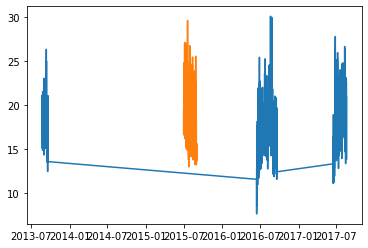

In [ ]:
# 2015

dat_train = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2015.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(5739, 51) (4417, 51) (1322, 51)


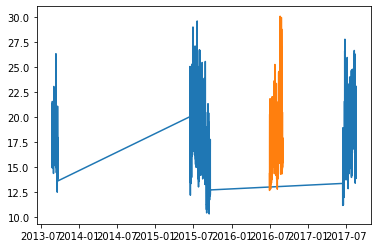

In [ ]:
# 2016

dat_train = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2016.pkl','rb'))

# check if 2015 train and test set are the same
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(6579, 51) (5028, 51) (1551, 51)


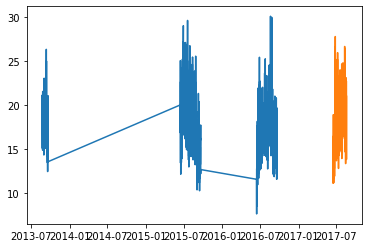

In [ ]:
# 2017

dat_train = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2017.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

### Restrict to time frames we want 

We want temperature data from all three summers, minus the smoky periods (smoke-affected days = when recorded incidences of regional forest fires)

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

In [ ]:
# 2015

# get training set from another year (so complete for 2015)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2015-06-01')
remove_after = pd.to_datetime('2015-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2015-07-01')
end_smoke = pd.to_datetime('2015-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2015 outdoor temps (x variable)
df_2015_X = df_3[['temp']]

In [ ]:
# 2016 

# get training set from another year (so complete for 2016)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2016-06-01')
remove_after = pd.to_datetime('2016-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# save 2016 outdoor temps (x variable)
df_2016_X = df_2[['temp']]

In [ ]:
# 2017

# get training set from another year (so complete for 2017)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2017-06-01')
remove_after = pd.to_datetime('2017-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2017-08-01')
end_smoke = pd.to_datetime('2017-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2017 outdoor temps (x variable)
df_2017_X = df_3[['temp']]

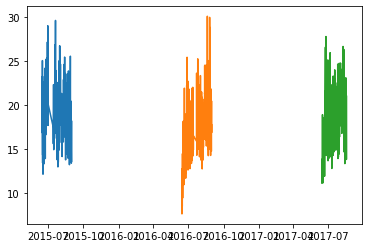

In [ ]:
# plot all outdoor temperatures in cleaned dataset
plt.plot(df_2015_X.index, df_2015_X.temp, df_2016_X.index, df_2016_X.temp, df_2017_X.index, df_2017_X.temp) 
plt.show() 

# save a single dataset with all days
ls_X = [df_2015_X, df_2016_X, df_2017_X]  
df_all_X = pd.concat(ls_X)

## GET INDOOR AIR TEMPERATURES FOR SAME TIME SPANS

In [ ]:
#Get raw data of indoor air temps (what we want to predict) 

df1 = pickle.load(open(DATA_PATH +'/trainY_2015.pkl','rb'))
df2 = pickle.load(open(DATA_PATH +'/trainY_2016.pkl','rb'))
df3 = pickle.load(open(DATA_PATH +'/trainY_2017.pkl','rb'))


# Put in all in one place 
ls_Y = [df1, df2, df3]  
df_Y = pd.concat(ls_Y)

# Drop duplicated date-times

df_Y = df_Y[~df_Y.index.duplicated(keep='first')]

# Drop date-times not in X set
df_all_Y = df_Y[df_Y.index.isin(df_all_X.index)]

## Plot X and Y variables

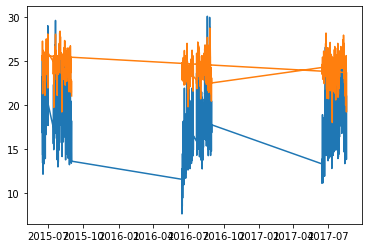

In [ ]:
# plot Outdoor (X values) and Indoor (to be predicted)
plt.plot(df_all_X.index, df_all_X.temp, df_all_Y.index, df_all_Y) 
plt.show() # Note LSTM assumes the book ends of a gap are adjacent, so it's good to see that there are no sharp changes over the gaps

## Add feature for time of day and transform variables

This step adds a variable to help the model understand the cyclicity of the 24 hours cycle
It borrows from the tutorial provided here: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

We want the machine to know that hours 23 and 0 are closer to each other than hours 0 and 4. We know that the period of the cycle is 24 hours. We can use the cos(x) and sin(x) functions. The x in the functions is the hour of the day.

In [ ]:
# Extract the hour of day
df_all_X["hour"] = df_all_X.index.hour
# Creating the cyclical daily feature 
df_all_X["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]
df_all_X["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]

# BiLSTM MODEL

The idea of Bidirectional LSTMs (BiSTM) is to use input information from both the past and future of a specific time step.

Some of the steps for making and fitting this model follow the tutorial found here: 
https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02

### Pre-processing to setup model: Split training/test sets, scale the data, shape the 3D matrix for feeding into the model

Note: for this type of time-step depending analysis, make sure training/test split shuffle is set to False (i.e., keep continguous chunks for training and testing)

In [ ]:
x = df_all_X.copy().to_numpy()
y = df_all_Y.copy().to_numpy()

# need to reshape Y which contains 1 features (currently it's 0) 
y = y.reshape(-1, 1)
 
# split the data into the train and test parts.
# NB split should not be a random selection... (shuffle=False)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, shuffle = False, test_size= 0.15)
 
train_dim = (X_train.shape, Y_train.shape)
test_dim = (X_test.shape, Y_test.shape)

# check
print("train_dim Xs and Y:", train_dim)
print("test_dim Xs and Y", test_dim)

train_dim Xs and Y: ((3937, 4), (3937, 1))
test_dim Xs and Y ((695, 4), (695, 1))


Scale and center the data:
1) variables are better to be small values, probably in the range of 0-1.
2) want the scale of the output variable is in the range 0-1 to match the scale of the activation function (tanh) on the output layer 

NB: we should scale the unseen tes data with the scaler fitted on the training data.

In [ ]:
# Fit the scaler with training data (used MinMaxScaler from sklearn)
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,100))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(Y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(Y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(Y_test)
test_x_norm = input_scaler.transform(X_test)

Create a 3D Input Dataset

This involves setting the 'time steps', which in this case will be the previous 48 hours

In [ ]:
#Default is one day back and one day forward
def create_dataset (X, y, time_steps = 24): 
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 72 # previous two days' weather

X_test, Y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, Y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', Y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', Y_train.shape)

X_train.shape:  (623, 72, 4)
y_train.shape:  (3865, 1)
X_test.shape:  (623, 72, 4)
y_test.shape:  (3865, 1)


## Create the BiLSTM model

The 'Bidirectional' wrapper will create two copies of the hidden layer, one fit in the input sequences as-is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be concatenated.

That means that instead of the TimeDistributed layer receiving 24 timesteps of X HIDDEN_LAYER units, it will now receive 24 timesteps of 2*X HIDDEN_LAYER units (X units + X units) outputs.

NB using MSE loss may yield 'too smooth' results... this will be revisited in the next round!

In [ ]:
# Create the BiLSTM model, use MSE loss function
# NB using MSE loss may yield 'too smooth' results... this will be revisited in the next round!

def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Choose the number of units (neurons) in hidden layers
HIDDEN_LAYERS = 64
model_bilstm = create_model_bilstm(HIDDEN_LAYERS)  

## Fit the model

Based on evaluations of loss functions... stop training after 1st epoch if using simple MSE

Epoch 1/2
97/97 [==============================] - 24s 180ms/step - loss: 0.0506 - val_loss: 0.0353
Epoch 2/2
97/97 [==============================] - 16s 163ms/step - loss: 0.0310 - val_loss: 0.0305


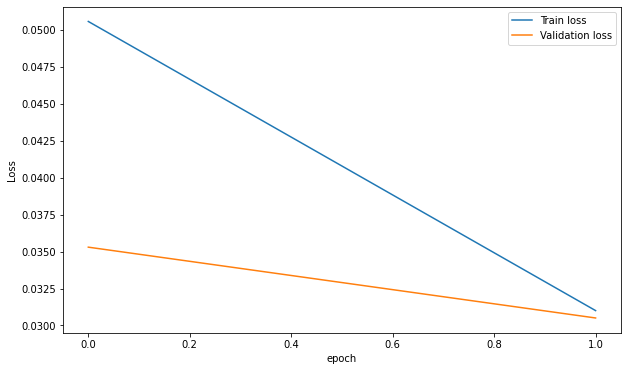

In [ ]:
# 1 epoch and batch_size = 32
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    # shuffle = False because the order of the data matters
    # use 20% of train data as validation data 
    history = model.fit(X_train, Y_train, epochs = 2, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history= fit_model(model_bilstm)

# Visualize the training loss versus validation loss
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig(FIGURES_PATH + '/BiLSTM_loss_plot with training and test sets continguous' +'.jpg', format='jpg', dpi=1000)
plt.show()

Last step! # Very important to transform the target variable back to original data space :)


In [ ]:
Y_test = scaler_y.inverse_transform(Y_test)
Y_train = scaler_y.inverse_transform(Y_train)

## Check Predictions of BiLSTM Model

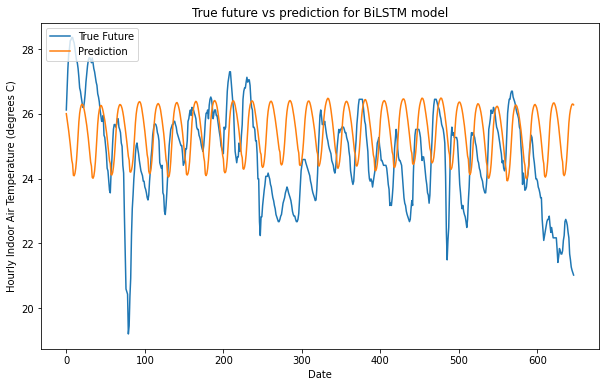

In [ ]:
prediction = model_bilstm.predict(X_test)
prediction = scaler_y.inverse_transform(prediction)
    
plt.figure(figsize=(10, 6))
range_future = len(prediction)

plt.plot(np.arange(range_future), np.array(Y_test), label='True Future')
plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

plt.title('True future vs prediction for BiLSTM model')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Hourly Indoor Air Temperature (degrees C)')

plt.savefig(FIGURES_PATH + '/Model Check on Test Set Keeping training test batches continguous' +'.jpg', format='jpg', dpi=1000)
plt.show()

In [ ]:
# Calculate MAE and RMSE

errors = prediction - Y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

Mean Absolute Error: 1.4347
Root Mean Square Error: 1.7916


# Improved BiLSTM model for sharpness of data: DILATE loss function

In the literature this type of input data might be called "sharp", and the default scaling and loss functions lead to "too smooth" predictions...

There are some special loss functions such as  DIstortion Loss including shApe and TimE (DILATE [link text](https://papers.nips.cc/paper/2019/file/466accbac9a66b805ba50e42ad715740-Paper.pdf)) or soft-dynamic time warping (soft-DTW) [link text](http://proceedings.mlr.press/v70/cuturi17a/cuturi17a.pdf)  which are specially designed for time series like this. 

See other notebook for this process

# ARCHIVED

In [ ]:
# 100 epoch and batch_size = 32
# early stop to stop training when "val_loss" has not improved after 10 epochs (patience = 10) to decrease risk of overfitting
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    # shuffle = False because the order of the data matters
    # use 20% of train data as validation data 
    history = model.fit(X_train, Y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_10epochs= fit_model(model_bilstm)

# Visualize the training loss versus validation loss
plt.figure(figsize = (10, 6))
plt.plot(history_10epochs.history['loss'])
plt.plot(history_10Epochs.history['val_loss'])

plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig(FIGURES_PATH + '/BiLSTM_loss_plot with training and test sets continguous' +'.jpg', format='jpg', dpi=1000)
plt.show()

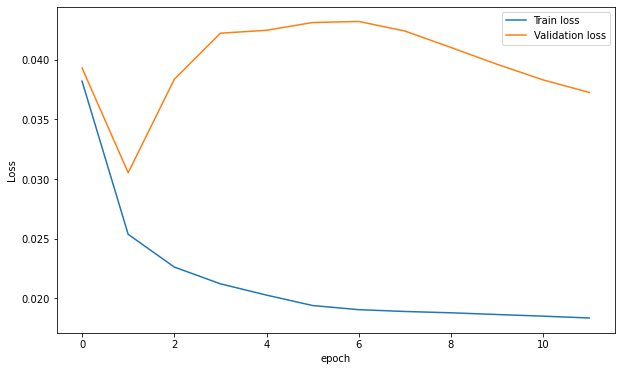